<a href="https://colab.research.google.com/github/kumiori/mec647/blob/igor-branche-2/mec647_TP_mesh-fix.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##ESTABLISHING CONNECTION OF THE COLAB WITH DOLFINX/FENICSX/DOCKER





In [1]:
%%capture
import sys

try:
    import google.colab  # noqa: F401
except ImportError:
    import ufl  # noqa: F401
    import dolfinx  # noqa: F401
else:
    try:
        import ufl
        import dolfinx
    except ImportError:
        !wget "https://fem-on-colab.github.io/releases/fenicsx-install.sh" -O "/tmp/fenicsx-install.sh" && bash "/tmp/fenicsx-install.sh";
        import ufl  # noqa: F401
        import dolfinx  # noqa: F401

In [2]:
%%capture
!sudo apt install libgl1-mesa-glx xvfb;
!{sys.executable} -m pip install pythreejs;
!{sys.executable} -m pip install ipygany;
!{sys.executable} -m pip install --upgrade pyyaml
try:
    import google.colab
except ImportError:
    pass
else:
    pass
    # google.colab.output.enable_custom_widget_manager();
try:
    import pyvista
except ImportError:
    !pip3 install --upgrade pyvista itkwidgets;
    import pyvista  # noqa: F401
    from pyvista.utilities import xvfb

# The problem of elasticity


Let $\Omega \subset (0, L)^D$, with $D=1, 2, 3$, $L$ finite, being the (or one) characteristic length of the specimen. For any $u\in V_t : H^1(\Omega, R^n) + bcs(t)$ with $n=1, 2$ or $3$, consider the energy $E(u)$ defined as
$$
E(u)=\frac{1}{2}\int_\Omega A e(u): e(u) dx - \int_\Omega f.u dx$$
Above, $A$ is the 4-th order tensor of elasticity, in the isotropic and homogeneous case, it corresponds to a linear combination with two coefficients, say, $A_0$ the stiffness (dimensional), and $\nu$ the Poisson ratio (non-dimensional). 

We solve:
$$min \left\{ E(u):  u \in V_t\right\}$$. 

From a mechanical  standpoint, linear elasticity is the limit regime of small deformations of the general, fully nonlinear, problem of elasticity.  
From a mathematical standpoint, the minimisation problem above is a standard variational problem which is i) convex, ii) defined on a complete, compact,  vector space of functions, and iii) . Its solution is unique and depends continuously upon the data. Can you show this?  

Boundary conditions are such that equilibrium ...

The interest of the above is that $E(u)$ ...


## A priori, we include the necessary libraries to run the simulation

In [3]:
#Numpy -> numerical library for Python. We'll use it for all array operations.
#It's written in C and it's faster (than traditional Python)
import numpy as np

#Yaml (Yet another markup language) -> We'll use it to pass, read and structure
#light text data in .yml files.
import yaml

#Json -> Another form to work with data. It comes from JavaScript. Similar functions
#that Yaml. Used speacily with API request, when we need data "fetch".
import json

#Communication with the machine:
#Sys -> allows to acess the system and launch commandes.
#Os - > allows to acess the operation system.
import sys
import os
from pathlib import Path

#Mpi4py -> Interface that allows parallel interoperability. MPI stands for' Message
#Passager Interface' and will be used to communicate computer nodes when lauching code
#in a parallel way

from mpi4py import MPI
#Petcs4py -> we use this library to handle with the data. Given acesses to solvers
import petsc4py
from petsc4py import PETSc

#Dolfinx
import dolfinx
import dolfinx.plot
from dolfinx import log
import logging

logging.basicConfig(level=logging.INFO)

import dolfinx
import dolfinx.plot
import dolfinx.io
from dolfinx.fem import (
    Constant,
    Function,
    FunctionSpace,
    assemble_scalar,
    dirichletbc,
    form,
    locate_dofs_geometrical,
    set_bc,
)

#UFL (Unified Format Language) -> we'll be used to represent abstract way to 
#represent the language in a quadratic form
import ufl

#XDMFF -> format used for the output binary data
from dolfinx.io import XDMFFile

#Install 'gmsh' library -> we'll be used for the mesh.
#!{sys.executable}: to use the current kernel to make the installation 
try:
    import gmsh
except ImportError:
    !{sys.executable} -m pip install gmsh
    import gmsh

import matplotlib.pyplot as plt

     |████████████████████████████████| 38.7 MB 1.2 MB/s 


## Clone the directory and files present in the GitHub to the colab document
In the GItHub, there are functions and 'libraries' needed to the simulation, such as the solver itself.

In [4]:
try:
  !git clone https://github.com/kumiori/mec647.git
  sys.path.append('mec647/') #Change the execution directory to the copied one
                              # from GitHub
except:
  pass

Cloning into 'mec647'...
remote: Enumerating objects: 510, done.
remote: Counting objects: 100% (510/510), done.
remote: Compressing objects: 100% (417/417), done.
remote: Total 510 (delta 214), reused 228 (delta 75), pack-reused 0
Receiving objects: 100% (510/510), 7.19 MiB | 11.47 MiB/s, done.
Resolving deltas: 100% (214/214), done.


In [5]:
# meshes
import meshes
from meshes import primitives

# visualisation
from utils import viz
import matplotlib.pyplot as plt
from utils.viz import plot_mesh, plot_vector, plot_scalar

## Defining parameters
In this section, the parameters necessary to be precissed by the user in order to run the simulation, such as material propreties, loading, geometry, etc., are defined. The parameters are defined using dictionaries.


In [ ]:
# Parameters

parameters = {
    #In case of evolution (nonlinear) problems, it's necessary to define a max
    #and a min. For the elastic solution, just one value in needed.
    'loading': {
        'min': 0,
        'max': 1
    },
    'geometry': {
        'geom_type': 'bar',
        'Lx': 1.,
        'Ly': 0.1
    },
    'material': {
        'E': 2e11,
        'poisson': 0.3
    },
    'solvers': {
        'snes': {
            'snes_type': 'newtontr',
            'snes_stol': 1e-8,
            'snes_atol': 1e-8,
            'snes_rtol': 1e-8,
            'snes_max_it': 100,
            'snes_monitor': "",
            'ksp_type': 'preonly',
            'pc_type': 'lu',
            'pc_factor_mat_solver_type': 'mumps'
        }
    }
}

# parameters.get('loading') -> this parameters can be defined and obtained from
# a external file. In the first exemple (mec647_VI_1), the parameters were
# read from a .yml file.



In [ ]:
# # Mesh
# Lx = parameters["geometry"]["Lx"]
# Ly = parameters["geometry"]["Ly"]
# geom_type = parameters["geometry"]["geom_type"]

# #When excuting this next import, we automatically import all functions present in 
# #'__init__.py'. Within this code, there are 2 really important to generate the 
# #mesh for the simulation: 'read_from_msh' (Reads a mesh from a msh-file and 
# #returns the dolfin-x mesh) and 'gmsh_model_to_mesh' (Given a GMSH model, create
# #a DOLFIN-X mesh and MeshTags).
# import meshes
# #dir(meshes) -> to see what's inside of the 'meshes' routine. Similar to 'ls'(for
# #Linux) or 'cd' (for Windows).

# #This next import, allows to generates simples GMSH model given the parameters
# #necessary. 
# from meshes import primitives

# #mesh_bar_gmshapi -> Create mesh of 3d tensile test specimen according to ISO 
# #6892-1:2019 using the Python API of Gmsh.

# gmsh_model, tdim = primitives.mesh_bar_gmshapi(geom_type,
#                                     Lx, 
#                                     Ly, 
#                                     0.1, 
#                                     tdim=2)

# mesh, mts = meshes.gmsh_model_to_mesh(gmsh_model,
#                                cell_data=False,
#                                facet_data=True,
#                                gdim=2)
# import matplotlib as plt
# #Plot mesh
# plt.figure()
# ax = plot_mesh(mesh)
# fig = ax.get_figure()
# fig.savefig(f"mesh.png")


In [14]:
def mesh_V(
a,
h,
L,
gamma,
de,
de2,
key=0,
show=False,
filename='mesh.unv'
):
    """
    Create a 2D mesh of a notched three-point flexure specimen using GMSH.
    a = height of the notch
    h = height of the specimen
    L = width of the specimen
    gamma = notch angle
    de = density of elements at specimen
    de2 = density of elements at the notch and crack
    key = 0 -> create model for Fenicxs (default)
          1 -> create model for Cast3M
    show = False -> doesn't open Gmsh to vizualise the mesh (default)
           True -> open Gmsh to vizualise the mesh
    filename = name and format of the output file for key = 1 
    """
    gmsh.initialize()
    gmsh.option.setNumber("General.Terminal",1)
    gmsh.option.setNumber("Mesh.Algorithm",6)
    model = gmsh.model()

    model.add('TPB')
    model.setCurrent('TPB')
    hopen = a*np.tan((gamma/2.0)*np.pi/180)
    c0 = h/10
    tdim = 2 
    #Generating the points of the geometrie
    p0 = model.geo.addPoint(0.0, a, 0.0, de2, tag=0)
    p1 = model.geo.addPoint(hopen, 0.0, 0.0, de, tag=1)
    p2 = model.geo.addPoint(L/2, 0.0, 0.0, de, tag=2)
    p3 = model.geo.addPoint(L/2, h, 0.0, de, tag=3)
    p4 = model.geo.addPoint(0.0, h, 0.0, de, tag=4)
    if key == 0:
        p5 = model.geo.addPoint(-L/2, h, 0.0, de, tag=5)
        p6 = model.geo.addPoint(-L/2, 0.0, 0.0, de, tag=6)
        p7 = model.geo.addPoint(-hopen, 0.0, 0.0, de, tag=7)
    elif key == 1:
        p20 = model.geo.addPoint(0, a+c0, 0, de2, tag=20)
    #Creating the lines by connecting the points
    notch_right = model.geo.addLine(p0, p1, tag=8) 
    bot_right = model.geo.addLine(p1, p2, tag=9)
    right = model.geo.addLine(p2, p3, tag=10)
    top_right = model.geo.addLine(p3, p4, tag=11)
    # if key == 0:
    top_left = model.geo.addLine(p4, p5, tag=12)
    left = model.geo.addLine(p5, p6, tag=13)
    bot_left = model.geo.addLine(p6, p7, tag=14)
    notch_left = model.geo.addLine(p7, p0, tag=15)
  # elif key == 1:
        # sym_plan = model.geo.addLine(p4, p20, tag=21)
        # fissure = model.geo.addLine(p20, p0, tag=22)
    #Creating the surface using the lines created
    # if key == 0:
    perimeter = model.geo.addCurveLoop([notch_right, bot_right, right, top_right, top_left, left, bot_left, notch_left])
    # elif key == 1:
    # perimeter = model.geo.addCurveLoop([notch_right, bot_right, right, top_right, sym_plan, fissure])
    surface = model.geo.addPlaneSurface([perimeter])
    #model.geo.addSurfaceLoop([surface,16])
    model.mesh.setOrder(1)
    model.geo.synchronize()

    #Creating Physical Groups to extract data from the geometrie
    # if key == 0:
    gmsh.model.addPhysicalGroup(tdim-1, [left], tag = 101)
    gmsh.model.setPhysicalName(tdim-1, 101,'Left')

    gmsh.model.addPhysicalGroup(tdim-1, [right], tag=102)
    gmsh.model.setPhysicalName(tdim-1, 102,'Right')

    gmsh.model.addPhysicalGroup(tdim-2, [p2], tag=103)
    gmsh.model.setPhysicalName(tdim-2, 103,'Left_point')

    gmsh.model.addPhysicalGroup(tdim-2, [p6], tag=104)
    gmsh.model.setPhysicalName(tdim-2, 104,'Right_point')

    gmsh.model.addPhysicalGroup(tdim-2, [p4], tag=105)
    gmsh.model.setPhysicalName(tdim-2, 105, 'Load_point')

    gmsh.model.addPhysicalGroup(tdim-2, [p0], tag=106)
    gmsh.model.setPhysicalName(tdim-2, 106, 'Notch_point')

    gmsh.model.addPhysicalGroup(tdim, [surface],tag=110)
    gmsh.model.setPhysicalName(tdim, 110, 'mesh_surface')
    
    # if key == 1:
    #     gmsh.model.addPhysicalGroup(tdim, [surface],tag=110)
    #     gmsh.model.setPhysicalName(tdim, 110, 'mesh_surface')

    #     gmsh.model.addPhysicalGroup(tdim-1, [fissure], tag=111)
    #     gmsh.model.setPhysicalName(tdim-1, 111, 'fissure')

    #     gmsh.model.addPhysicalGroup(tdim-1, [sym_plan], tag=112)
    #     gmsh.model.setPhysicalName(tdim-1, 112, 'sym_plan')

    #     gmsh.model.addPhysicalGroup(tdim-2, [p20], tag=113)
    #     gmsh.model.setPhysicalName(tdim-2, 113, 'Crack_tip')
   
    #Generating the mesh
    model.geo.synchronize()
    model.mesh.generate(tdim)
    # if show:
    #     gmsh.fltk.run()
    # if key == 1:
    #     gmsh.write(filename)
    return gmsh.model

In [15]:
mesh_V(a=.1,h=.3,L=1.,gamma=90,de=.1,de2=.1,key=0)

gmsh.model

In [ ]:
from meshes import primitives
mesh=primitives.mesh_bar_gmshapi('test',1,0.1,0.1,2)

In [ ]:
a=0.00533
h=0.0178
L=0.0762
gamma = 90
de = a/5
de2 = a/10
gmsh_model = mesh_V(a, h, L, gamma, de, de2)
mesh = meshes.gmsh_model_to_mesh(gmsh_model, gdim=2)

Exception: ignored

AttributeError: ignored

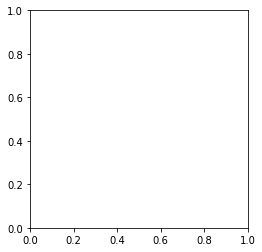

In [ ]:
# import matplotlib.pyplot as plt
#Plot mesh
plt.figure()
ax = plot_mesh(mesh)
fig = ax.get_figure()
fig.savefig(f"mesh.png")

## Defining the finite element type and others functional setting

In [ ]:
# Functional setting
#'u' represents the displacement in this problem. In order to solve it, the 
#continuos field  'u' is replaced by a discrite form u = som[vec(function_forme)
#*vec(nodal_displacement)]
#In order to define the vec(function_forme), the ufl library is used. 

#A VectorElement represents a combination of basic elements such that each
#component of a vector is represented by the basic element. The size is usually
#omitted, the default size equals the geometry dimension.

#ulf.VectorElement(<Type of the element>, <Geometry of the element>, 
#degree=<Degree of element: 1 - Linear, 2 - Quadratic, etc.>, dim= <Target 
#dimension of the element: 1 - Line, 2 - Area, 3 - Volume>)

#Lagrange is a familly type of elements -> polynomial functions of forme;
#The Lagrange elements are going to be defined in the mesh as such we take the
#geometry of elements present in the mesh.

element_u = ufl.VectorElement("Lagrange", mesh.ufl_cell(),
                              degree=1, dim=2)

#After defining the Finite Element in ufl, a association with dolfinx is made.
#To inputs are necessary, the mesh and the element type created. In some sense, 
#we obtain the "discretised model w/ elements definied".
V_u = dolfinx.fem.FunctionSpace(mesh, element_u) 
#In this model, we also defines functions necessaries to solve the problem. 
#This functions are definied in the entire space/model.
u = dolfinx.fem.Function(V_u, name="Displacement") #The discrete nodal valeus of
                                                    #the displacement
g = dolfinx.fem.Function(V_u, name="Body_pressure")
with g.vector.localForm() as loc:
  loc.set(78500.0)
#In order to defined a function in a specific subspace of the model, it must be 
#specified in the model 'V_u.sub(i)', where i = 0 -> x, 1 -> y, 2-> z.
#Don't forget to collapse, to choose only the DOF associated with the subspace.


In [ ]:
#Functions necessaries for the Bondary conditions
u_ = dolfinx.fem.Function(V_u, name="Boundary_displacement")
#In order to defined a function in a specific subspace of the model, it must be 
#specified in the model 'V_u.sub(i)', where i = 0 -> x, 1 -> y, 2-> z.
#Don't forget to collapse, to choose only the DOF associated with the subspace.
# ux_ = dolfinx.fem.Function(V_u.sub(0).collapse(), name="Boundary Displacement")


zero = Function(V_u)
# works in parallel!
with zero.vector.localForm() as loc:
    loc.set(0.0)

one = Function(V_u)
# works in parallel!
with one.vector.localForm() as loc:
    loc.set(1.0)

# g = Function(V_u)
# # works in parallel!
# with zero.vector.localForm() as loc:
#     loc.set(0.0)


##Defining  the energy function

In [ ]:
# Integral measures -> in order to define the energy lately, it's necessary to 
#define the integral measures, as such one is a integral.
dx = ufl.Measure("dx", domain=mesh) #-> volume measure
ds = ufl.Measure("ds", domain=mesh) #-> surface measure


In [ ]:
#Getting material parameters 
E = parameters["material"]["E"]
poisson = parameters["material"]["poisson"]
mu = E/(2*(1+poisson))
lmbda = E*poisson/((1+poisson)*(1-2*poisson)) #carefull, lambda is a reserved word in Py

#Defining a function that returns a way to calculate the deformation, which is 
#symmetric part of the gradient of the displacement.
def _e(u):
  return ufl.sym(ufl.grad(u))

en_density = 1/2 * (2*mu* ufl.inner(_e(u),_e(u))) + lmbda*ufl.tr(_e(u))**2
energy = en_density * dx - ufl.dot(g, u) * dx

### Boundary parts

Boundary entities, that is facets  of dimension $n-1$, are identified geometrically by ```locate_entities_boundary```. 
Its last argument is a function of the (discrete) point $x$ (here, ```left(x)``` and ```right(x)```) returning whether or not (```True/False```) the point belongs to the boundary.

Here, the 'right_facets' and 'left_facets' returns the numbers of the nodes where the BCs is going to be applied. The functions has as input: the mesh, the dimension of the mesh you wanna apply the BC (1 for lines, 2 for surfaces and 3 for volumes) and a function that returns 'TRUE' if the point of the mesh is in the region you want to apply the BC.

In [ ]:
# boundary conditions

def left(x):
  return np.isclose(x[0], -L/2)

def right(x):
  return np.isclose(x[0], L/2)

left_facets = dolfinx.mesh.locate_entities_boundary(mesh, 0, left)
left_dofs = dolfinx.fem.locate_dofs_topological(V_u, mesh.topology.dim - 1,
                                                left_facets)

right_facets = dolfinx.mesh.locate_entities_boundary(mesh, 0, right)
right_dofs = dolfinx.fem.locate_dofs_topological(V_u, mesh.topology.dim - 1,
                                                right_facets)


In [ ]:
bcs = [dirichletbc(zero, left_dofs), dirichletbc(zero, right_dofs)]

In [ ]:
left_facets
left_dofs

array([ 0,  1,  2,  3,  4,  5,  7,  8,  9, 12, 13, 14, 15, 16, 17, 18, 19,
       20, 21, 22, 26, 27, 32, 33], dtype=int32)

## The problem, the solver.

The problem class ```SNESSolver``` gives access to (a range of) 
[Scalable Nonlinear Equations Solvers](https://petsc4py.readthedocs.io/en/stable/manual/snes/) setting up the necessary residual function (the energy gradient), a pointer to boundary conditions, and the interval bounds.


Internally, ```SNESSolver``` computes the Jacobian of the energy function by automatic differentiation. Check ```mec647/solvers/__init__.py``` for the details.

In [ ]:

# solving
from solvers import SNESSolver
D_energy_u = ufl.derivative(energy, u, ufl.TestFunction(V_u))

problem = SNESSolver(
    D_energy_u,
    u,
    bcs,
    bounds=None,
    petsc_options=parameters.get("solvers").get("snes"),
    prefix="elast",
)


problem.solve()


  0 SNES Function norm 3.686885308680e+00 
  1 SNES Function norm 4.029897442594e-11 


(1, 2)

In [ ]:

def plot_vector(u, plotter, subplot=None):
    if subplot:
        plotter.subplot(subplot[0], subplot[1])
    V = u.function_space
    mesh = V.mesh
    topology, cell_types, _ = dolfinx.plot.create_vtk_mesh(mesh, mesh.topology.dim)
    num_dofs_local = u.function_space.dofmap.index_map.size_local
    geometry = u.function_space.tabulate_dof_coordinates()[:num_dofs_local]
    values = np.zeros((V.dofmap.index_map.size_local, 3), dtype=np.float64)
    values[:, : mesh.geometry.dim] = u.vector.array.real.reshape(
        V.dofmap.index_map.size_local, V.dofmap.index_map_bs
    )
    grid = pyvista.UnstructuredGrid(topology, cell_types, geometry)
    grid["vectors"] = values
    grid.set_active_vectors("vectors")
    # geom = pyvista.Arrow()
    # glyphs = grid.glyph(orient="vectors", factor=1, geom=geom)
    glyphs = grid.glyph(orient="vectors", factor=1.0)
    plotter.add_mesh(glyphs)
    plotter.add_mesh(
        grid, show_edges=True, color="black", style="wireframe", opacity=0.3
    )
    plotter.view_xy()
    return plotter


def plot_scalar(alpha, plotter, subplot=None, lineproperties={}):
    if subplot:
        plotter.subplot(subplot[0], subplot[1])
    V = alpha.function_space
    mesh = V.mesh
    topology, cell_types, _ = dolfinx.plot.create_vtk_mesh(mesh, mesh.topology.dim)
    grid = pyvista.UnstructuredGrid(topology, cell_types, mesh.geometry.x)

    plotter.subplot(0, 0)
    grid.point_data["alpha"] = alpha.compute_point_values().real
    grid.set_active_scalars("alpha")
    plotter.add_mesh(grid, **lineproperties)
    plotter.view_xy()
    return plotter


In [ ]:
# plt.figure()
# ax = plot_mesh(mesh)
# fig = ax.get_figure()
# fig.savefig(f"mesh.png")

# postprocessing
xvfb.start_xvfb(wait=0.05)
pyvista.OFF_SCREEN = True
plotter = pyvista.Plotter(
        title="Displacement",
        window_size=[1600, 600],
        shape=(1, 1),
    )
# plt = plot_scalar(u.sub(0), plotter, subplot=(0, 0))
_plt = plot_vector(u, plotter, subplot=(0, 0))

_plt.screenshot(f"displacement_MPI.png")

array([[[76, 76, 76],
        [76, 76, 76],
        [76, 76, 76],
        ...,
        [76, 76, 76],
        [76, 76, 76],
        [76, 76, 76]],

       [[76, 76, 76],
        [76, 76, 76],
        [76, 76, 76],
        ...,
        [76, 76, 76],
        [76, 76, 76],
        [76, 76, 76]],

       [[76, 76, 76],
        [76, 76, 76],
        [76, 76, 76],
        ...,
        [76, 76, 76],
        [76, 76, 76],
        [76, 76, 76]],

       ...,

       [[76, 76, 76],
        [76, 76, 76],
        [76, 76, 76],
        ...,
        [76, 76, 76],
        [76, 76, 76],
        [76, 76, 76]],

       [[76, 76, 76],
        [76, 76, 76],
        [76, 76, 76],
        ...,
        [76, 76, 76],
        [76, 76, 76],
        [76, 76, 76]],

       [[76, 76, 76],
        [76, 76, 76],
        [76, 76, 76],
        ...,
        [76, 76, 76],
        [76, 76, 76],
        [76, 76, 76]]], dtype=uint8)

In [ ]:


# plt.figure()
# ax = plot_mesh(mesh)
# fig = ax.get_figure()
# fig.savefig(f"mesh.png")

# postprocessing
plotter = pyvista.Plotter(
        title="Displacement",
        window_size=[1600, 600],
        shape=(1, 2),
    )

# _plt = plot_scalar(u_.sub(0), plotter, subplot=(0, 0))
_plt = plot_vector(u, plotter, subplot=(0, 1))
_plt.screenshot(f"displacement_MPI.png")

array([[[ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0],
        ...,
        [ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0]],

       [[ 0,  0,  0],
        [76, 76, 76],
        [76, 76, 76],
        ...,
        [76, 76, 76],
        [76, 76, 76],
        [ 0,  0,  0]],

       [[ 0,  0,  0],
        [76, 76, 76],
        [76, 76, 76],
        ...,
        [76, 76, 76],
        [76, 76, 76],
        [ 0,  0,  0]],

       ...,

       [[ 0,  0,  0],
        [76, 76, 76],
        [76, 76, 76],
        ...,
        [76, 76, 76],
        [76, 76, 76],
        [ 0,  0,  0]],

       [[ 0,  0,  0],
        [76, 76, 76],
        [76, 76, 76],
        ...,
        [76, 76, 76],
        [76, 76, 76],
        [ 0,  0,  0]],

       [[ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0],
        ...,
        [ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0]]], dtype=uint8)

In [ ]:
print(u)
#viz.plot_vector()

Displacement
